In [1]:
!pip install transformers
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

# !pip install -q torch-geometric


     |████████████████████████████████| 4.2 MB 14.5 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 57.9 MB/s 
     |████████████████████████████████| 6.6 MB 56.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:

from collections import defaultdict
from pprint import pprint
from typing import Union, Any, Optional, List, Tuple

import torch.nn
from matplotlib import pyplot as plt
import torch.nn.functional as F
import torch
from dataclasses import dataclass
from enum import Enum, auto
from functools import partial

from abc import ABC, abstractmethod

from torch import Tensor, nn
from typing import TypeVar

import numpy as np

from hashlib import sha256


In [3]:

print(torch.cuda.is_available())

True


In [4]:
# utils.py


from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


def hash_string(string: str):
    return sha256(string.encode('utf-8')).hexdigest()


def path_to(name):
    return "/content/gdrive/MyDrive/bakalarka/data/clutrr/" + name
    # return "/Users/boris.rakovan/Desktop/school/thesis/code/data/clutrr/" + name


def make_batches(size: int, batch_size: int):
    nb_batch = int(np.ceil(size / float(batch_size)))
    res = [(i * batch_size, min(size, (i + 1) * batch_size)) for i in range(0, nb_batch)]
    return res


T = TypeVar("T")


def transpose_2d_list(lst):
    return list(map(list, zip(*lst)))


def pad_sequences(sequences, max_len=None, dtype='int32', padding='post', truncating='post', value=0.):
    """
    Copied from some ML project

    Pads each sequence to the same length (length of the longest sequence).

    If maxlen is provided, any sequence longer
    than maxlen is truncated to maxlen.
    Truncation happens off either the beginning (default) or
    the end of the sequence.

    Supports post-padding and pre-padding (default).

    # Arguments
        sequences: list of lists where each element is a sequence
        max_len: int, maximum length
        dtype: type to cast the resulting sequence.
        padding: 'pre' or 'post', pad either before or after each sequence.
        truncating: 'pre' or 'post', remove values from sequences larger than
            max_len either in the beginning or in the end of the sequence
        value: float, value to pad the sequences to the desired value.

    # Returns
        x: numpy array with dimensions (number_of_sequences, max_len)

    # Raises
        ValueError: in case of invalid values for `truncating` or `padding`,
            or in case of invalid shape for a `sequences` entry.
    """
    lengths = [len(x) for x in sequences]

    num_samples = len(sequences)
    if max_len is None:
        max_len = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    x = (np.ones((num_samples, max_len) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-max_len:]
        elif truncating == 'post':
            trunc = s[:max_len]
        else:
            raise ValueError('Truncating type "%s" not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x


Mounted at /content/gdrive


In [5]:
from transformers import DistilBertTokenizer, DistilBertModel
# from transformers import BertModel, BertTokenizerFast

class BaseNet(ABC, nn.Module):
    @abstractmethod
    def forward(self, input_batch) -> Tensor:
        ...


class Bert(BaseNet):
    def __init__(self, target_size: int):
        super().__init__()
        self.tokenizer_params = {
            "max_length": 200,
            "padding": True,
            "return_tensors": "pt",
        }

        # self.model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased", return_dict=True)

        # for param in self.model.parameters():
            # param.requires_grad = False

        # self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        
        self.lin1 = nn.Linear(in_features=768, out_features=512)
        self.lin2 = nn.Linear(in_features=512, out_features=target_size)

    def forward(self, input_batch) -> Tensor:
        
        # print(self.model.device)
        raw_stories = [inst.bert_story for inst in input_batch.instances]

        inputs = self.tokenizer(raw_stories, **self.tokenizer_params).to(self.model.device)        

        last_hidden_state, = self.model(**inputs, return_dict=False)
        last_hidden_state = last_hidden_state[:, 0, :]

        # print(pooled_output.device)

        x = self.lin1(last_hidden_state)
        # print(x.device)

        x = F.relu(x)
        x = self.lin2(x)
        # print(x.device)
        # print(self.model.device)
        # print(pooled_output.device)

        return x


In [6]:

# clutrr/preprocess.py

import yaml

import csv
import json

from collections import OrderedDict


# _CLUTRR_DATASET = "data_089907f8/"
_CLUTRR_DATASET = "data_db9b8f04/"

_TEST_FILES = [
    "1.2_test.csv",
    "1.3_test.csv",
    "1.4_test.csv",
    "1.5_test.csv",
    "1.6_test.csv",
    "1.7_test.csv",
    "1.8_test.csv",
    "1.9_test.csv",
    "1.10_test.csv",
]

TRAIN_FILE = "1.2,1.3,1.4_train.csv"


with open(path_to("relations_store.yaml"), 'r') as f:
    relations_dict = yaml.safe_load(f)

Fact = Tuple[str, str, str]
Story = List[Fact]


class Instance:
    def __init__(self,
                 story: Story,
                 target: Fact,
                 raw_story: str,
                 num_nodes: Optional[int] = None):
        self._story = story
        self._target = target
        self._raw_story = raw_story
        self._num_nodes = num_nodes

        self._bert_story = f'{self.target[0]} {self.target[2]} [SEP] {self._raw_story.replace("[", "").replace("]", "")}'
        
    @property
    def story(self) -> Story:
        return self._story

    @property
    def target(self) -> Fact:
        return self._target

    @property
    def bert_story(self) -> str:
        return self._bert_story
        
    @property
    def num_nodes(self) -> Optional[int]:
        return self._num_nodes

    def __str__(self) -> str:
        return f'{self.story}\t{self.target}'


class Data:
    def __init__(
        self,
        train_path,
        test_paths: Optional[List[str]] = None,
        with_tagged_entities: bool = False
    ):
        self.relation_to_predicate = {r['rel']: k for k, v in relations_dict.items()
                                      for _, r in v.items() if k != 'no-relation'}

        self.relation_lst = sorted({r for r in self.relation_to_predicate.keys()})

        self.relation_to_idx = {rel: idx for idx, rel in enumerate(self.relation_lst)}

        self._train_instances = Data.parse(train_path, with_tagged_entities)
        entity_set = {s for i in self.train for (s, _, _) in i.story} | {o for i in self.train for (_, _, o) in i.story}

        self._test_instances = OrderedDict()
        for test_path in (test_paths if test_paths is not None else []):
            i_lst = self._test_instances[test_path] = Data.parse(test_path, with_tagged_entities)
            entity_set |= {s for i in i_lst for (s, _, _) in i.story} | {o for i in i_lst for (_, _, o) in i.story}

        self.entity_lst = sorted(entity_set)

        for instance in self.train:
            for s, r, o in instance.story:
                assert s in self.entity_lst and o in self.entity_lst
                assert r in self.relation_lst

    @property
    def train(self) -> List[Instance]:
        return self._train_instances

    @property
    def test(self):
        return self._test_instances

    @staticmethod
    def _to_obj(s: str) -> Any:
        return json.loads(s.replace(")", "]").replace("(", "[").replace("'", "\""))

    @staticmethod
    def parse(path: str, with_tagged_entities: bool) -> List[Instance]:
        res = []
        with open(path, newline='') as f:
            reader = csv.reader(f)
            for i, row in enumerate(reader):
                _id, _, raw_story, query, _, target, _, _, _, _, _, story_edges, edge_types, _, genders, _, tmp, _ = row
                if len(_id) > 0:
                    num_nodes = int(tmp[tmp.rfind(":") + 2:-1]) + 1
                    id_to_name = {i: name.split(':')[0] for i, name in enumerate(genders.split(','))}
                    _story, _edge, _query = Data._to_obj(story_edges), Data._to_obj(edge_types), Data._to_obj(query)
                    triples = [(id_to_name[s_id], p, id_to_name[o_id]) for (s_id, o_id), p in zip(_story, _edge)]
                    target = (_query[0], target, _query[1])
                    raw_story = raw_story if with_tagged_entities else raw_story.replace("[", "").replace("]", "")
                    instance = Instance(triples, target, raw_story, num_nodes=num_nodes)
                    res += [instance]
        return res


def load_clutrr(with_tagged_entities: bool = True) -> Data:
    return Data(
        train_path=path_to(_CLUTRR_DATASET + TRAIN_FILE),
        test_paths=[path_to(_CLUTRR_DATASET + tf) for tf in _TEST_FILES],
        with_tagged_entities=with_tagged_entities
    )


In [7]:
# models/factory.py


class ModelType(str, Enum):
    GCN = "GCN"
    GCN_MP = "GCN_MP"
    GCN_BASELINE = "GCN_BASELINE"
    EDGE_GCN = "EDGE_GCN"
    EDGE_GAT = "EDGE_GAT"
    RNN = "RNN"
    BI_RNN = "BI_RNN"
    LSTM = "LSTM"
    FEED_FORWARD = "FEED_FORWARD"
    BERT = "BERT"
    FEED_FORWARD_POS = "FEED_FORWARD_POS"

    def __repr__(self):
        return self.value


def create_model(
    model_type: ModelType,
    num_nodes: int,
    edge_dim: int,
    target_size: int,
    relation_lst: List[str],
    device: Any,
    seq_embed_dim: int = 100,
) -> BaseNet:

    model = Bert(target_size=target_size)
    return model.to(device)


In [8]:
# schemas

@dataclass
class GeoDataMock:
    y: Tensor


@dataclass
class InputBatch:
    geo_batch: GeoDataMock  # Batch
    targets: Tensor
    instances: List[Instance]


@dataclass(frozen=True)
class TrainConfig:
    batch_size: int
    num_epochs: int
    lr: float
    evaluate_every: int = 10


@dataclass(frozen=True)
class Experiment:
    model_type: ModelType
    graph_factory_cls: Any
    train_config: TrainConfig
    num_training_samples: int = -1


TrainHistory = Any


In [9]:
import os 
import pickle
import itertools
from transformers import AdamW


def store_results(experiment: Experiment, train_history: TrainHistory) -> None:
    fingerprint = hash_string(str(experiment))[:16]
    path = "/content/gdrive/MyDrive/bakalarka/results/" + fingerprint + ".pickle"

    with open(path, "wb") as out:
        pickle.dump((experiment, train_history), out)

    print(f"Experiment results stored in {path}")

def run_experiment(experiment: Experiment):
    clutrr_data = load_clutrr()

    device = torch.device('cuda')

    train_instances = (
        clutrr_data.train[:experiment.num_training_samples]
        if experiment.num_training_samples != -1 else clutrr_data.train
    )

    graph_factory = experiment.graph_factory_cls(
        entity_lst=clutrr_data.entity_lst,
        relation_lst=clutrr_data.relation_lst,
        batch_size=experiment.train_config.batch_size,
        device=device
    )
    train_data = graph_factory.create_batches(train_instances)

    test_data = {}
    for test_name in clutrr_data.test:
        test_instances = clutrr_data.test[test_name]
        test_batches = graph_factory.create_batches(test_instances)
        test_name = test_name.split("/")[-1]
        test_data[test_name] = test_batches

    model = create_model(
        model_type=experiment.model_type,
        num_nodes=graph_factory.input_dim,
        edge_dim=graph_factory.edge_dim,
        target_size=len(clutrr_data.relation_lst),
        relation_lst=clutrr_data.relation_lst,
        device=device,
    )

    train_history = training_loop(model, experiment.train_config, train_data, test_data)

    show_plots(train_history, experiment.train_config)

    experiment_summary(experiment, train_history)

    store_results(experiment, train_history)


def training_loop(
    model: BaseNet,
    train_config: TrainConfig,
    train_data: List[InputBatch],
    test_data,
) -> TrainHistory:
    # optimizer = torch.optim.Adam(model.parameters(), lr=train_config.lr)  # weight_decay=5e-4

    head_params = itertools.chain(model.lin1.parameters(), model.lin2.parameters())
    
    bert_optimizer = AdamW(model.model.parameters(), lr=5e-5)
    head_optimizer = AdamW(head_params, lr=1e-3)

    history: TrainHistory = {
        "train_losses": [],
        "train_acc": [],
        "test_acc": defaultdict(list),
    }

    for epoch in range(train_config.num_epochs):
        batch_loss = 0.
        correct = 0
        num_samples = 0
        model.train()

        for batch in train_data:
            logits = model(batch)
            y = batch.geo_batch.y.squeeze(1)
            loss = F.cross_entropy(logits, y, reduction='sum')
            batch_loss += loss.item()

            predictions = logits.max(dim=1)[1]
            correct += predictions.eq(y).sum().item()
            num_samples += predictions.size(0)

            loss.backward()
            
            head_optimizer.step()
            bert_optimizer.step()
            model.zero_grad()

        avg_loss = batch_loss / num_samples
        history["train_losses"].append(avg_loss)
        train_accuracy = correct / num_samples
        history["train_acc"].append(train_accuracy)

        print(f'Epoch: {epoch:03d}, Train Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}')

        if epoch % train_config.evaluate_every == 0:
            print("testing")
            for index, test_name in enumerate(test_data):
                test_accuracy = test(test_data[test_name], model)
                history["test_acc"][test_name].append(test_accuracy)
                print(f'Epoch: {epoch:03d}, Test Set: {test_name}, Accuracy: {test_accuracy:.4f}')

    return history


def test(test_data: List[InputBatch], model: BaseNet) -> float:
    correct = 0
    total = 0
    model.eval()

    for test_batch in test_data:
        test_logits = model(test_batch)
        test_predictions = test_logits.max(dim=1)[1]
        test_true = test_batch.geo_batch.y.squeeze(1)
        correct += test_predictions.eq(test_true).sum().item()
        total += test_predictions.size(0)
    return correct / total


def show_plots(history: TrainHistory, train_config: TrainConfig) -> None:
    num_epochs = train_config.num_epochs

    def plot_variable(var: list, var_name: str, var_label: Union[str, list], y_lim: float = None):
        plt.ylabel(var_name)
        plt.xlabel("Epoch")

        x_marks = num_epochs // len(var) + (0 if num_epochs % len(var) == 0 else 1)
        x = torch.arange(0, num_epochs, x_marks)
        plt.xlim(0, num_epochs)
        if y_lim:
            plt.ylim(0, y_lim)

        plt.plot(x, var, label=var_label)
        plt.legend()
        plt.show()

    # plot_variable(history["train_losses"], "Loss", "Average loss")
    # plot_variable(history["train_acc"], "Train acc", "Train accuraccy")

    test_vars = [test_acc for test_acc in history["test_acc"].values()]
    test_labels = [test_name for test_name in history["test_acc"]]
    plot_variable(transpose_2d_list(test_vars), "Test acc", test_labels, y_lim=1.1)


def experiment_summary(experiment: Experiment, train_history: TrainHistory) -> None:
    print("===========EXPERIMENT SUMMARY===========")
    pprint(experiment)
    print(f'Train loss: {min(train_history["train_losses"]):.4f}')
    print(f'Train accuracy: {max(train_history["train_acc"]):.4f}')
    for test_name, test_acc in train_history["test_acc"].items():
        print(f'Test Set: {test_name}, Accuracy: {max(test_acc):.4f}')
    print("========================================")


In [10]:
from abc import ABC, abstractmethod

Edge = Tuple[int, int]



class GraphFactory(ABC):
    def __init__(
        self,
        entity_lst: List[str],
        relation_lst: List[str],
        batch_size: int,
        device: Any
    ):
        self.entity_lst = entity_lst
        self.relation_lst = relation_lst
        self.relation_to_idx = {rel: idx for idx, rel in enumerate(self.relation_lst)}

        self.batch_size = batch_size
        self.device = device

    @property
    @abstractmethod
    def input_dim(self) -> int:
        ...

    @property
    @abstractmethod
    def edge_dim(self) -> int:
        ...

    @abstractmethod
    def _construct_graph(self, instance: Instance, max_num_entities: int) -> Tuple[Data, Edge]:
        ...

    def create_batches(self, instances: List[Instance]) -> List[InputBatch]:
        num_instances = len(instances)
        batches = make_batches(num_instances, self.batch_size)

        res = []
        for i, (batch_start, batch_end) in enumerate(batches):
            if i > 0 and i % 40 == 0:
                print(f"Processed {i}/{len(batches)}")
            batch_instances = instances[batch_start:batch_end]
            max_num_entities = max(i.num_nodes for i in batch_instances)

            batch_data = [
                self._construct_graph(inst, max_num_entities)
                for inst in batch_instances
            ]
            ys = [x[0] for x in batch_data]
            raw_targets = [list(x[1]) for x in batch_data]

            y = torch.tensor(ys, dtype=torch.long, device=self.device).unsqueeze(-1)
            targets = torch.tensor(raw_targets, dtype=torch.long, device=self.device)
            batch = InputBatch(GeoDataMock(y=y), targets, batch_instances)
            res.append(batch)

        return res

class KinshipGraph(GraphFactory):
    @property
    def input_dim(self) -> int:
        return len(self.entity_lst)

    @property
    def edge_dim(self) -> int:
        return len(self.relation_lst)

    def _construct_graph(self, instance: Instance, max_num_entities: int):
        entity_lst = sorted({x for t in instance.story for x in {t[0], t[2]}})
        entity_to_idx = {e: i for i, e in enumerate(entity_lst)}
        y = self.relation_to_idx[instance.target[1]]
        target_edge = (entity_to_idx[instance.target[0]], entity_to_idx[instance.target[2]])
        return y, target_edge

In [11]:
experiment = Experiment(
    model_type=ModelType.BERT,
    graph_factory_cls=KinshipGraph,
    train_config=TrainConfig(
        batch_size=64,
        num_epochs=20,
        lr=0.001,
    ),
)

Running experiment: Experiment(model_type=BERT, graph_factory_cls=<class '__main__.KinshipGraph'>, train_config=TrainConfig(batch_size=64, num_epochs=20, lr=0.001, evaluate_every=10), num_training_samples=-1)
Processed 40/236
Processed 80/236
Processed 120/236
Processed 160/236
Processed 200/236


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to

Epoch: 000, Train Loss: 1.1899, Accuracy: 0.6014
testing
Epoch: 000, Test Set: 1.2_test.csv, Accuracy: 0.0000
Epoch: 000, Test Set: 1.3_test.csv, Accuracy: 0.5047
Epoch: 000, Test Set: 1.4_test.csv, Accuracy: 0.9221
Epoch: 000, Test Set: 1.5_test.csv, Accuracy: 0.1189
Epoch: 000, Test Set: 1.6_test.csv, Accuracy: 0.2095
Epoch: 000, Test Set: 1.7_test.csv, Accuracy: 0.1871
Epoch: 000, Test Set: 1.8_test.csv, Accuracy: 0.1407
Epoch: 000, Test Set: 1.9_test.csv, Accuracy: 0.1694
Epoch: 000, Test Set: 1.10_test.csv, Accuracy: 0.2295
Epoch: 001, Train Loss: 0.4518, Accuracy: 0.8581
Epoch: 002, Train Loss: 0.1961, Accuracy: 0.9433
Epoch: 003, Train Loss: 0.1196, Accuracy: 0.9662
Epoch: 004, Train Loss: 0.0769, Accuracy: 0.9765
Epoch: 005, Train Loss: 0.0486, Accuracy: 0.9846
Epoch: 006, Train Loss: 0.0406, Accuracy: 0.9858
Epoch: 007, Train Loss: 0.0233, Accuracy: 0.9918
Epoch: 008, Train Loss: 0.0207, Accuracy: 0.9936
Epoch: 009, Train Loss: 0.0174, Accuracy: 0.9938
Epoch: 010, Train Loss: 

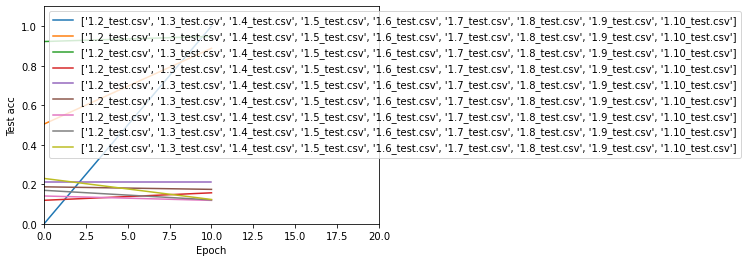

===========EXPERIMENT SUMMARY===========
Experiment(model_type=BERT, graph_factory_cls=<class '__main__.KinshipGraph'>, train_config=TrainConfig(batch_size=64, num_epochs=20, lr=0.001, evaluate_every=10), num_training_samples=-1)
Train loss: 0.0043
Train accuracy: 0.9989
Test Set: 1.2_test.csv, Accuracy: 1.0000
Test Set: 1.3_test.csv, Accuracy: 0.8879
Test Set: 1.4_test.csv, Accuracy: 0.9481
Test Set: 1.5_test.csv, Accuracy: 0.1568
Test Set: 1.6_test.csv, Accuracy: 0.2095
Test Set: 1.7_test.csv, Accuracy: 0.1871
Test Set: 1.8_test.csv, Accuracy: 0.1407
Test Set: 1.9_test.csv, Accuracy: 0.1694
Test Set: 1.10_test.csv, Accuracy: 0.2295
Experiment results stored in /content/gdrive/MyDrive/bakalarka/results/87f8d6a18ccd8c27.pickle
Finished in 2174.98 seconds


In [29]:
import time

start = time.time()



print(f"Running experiment: {experiment}")
run_experiment(experiment)

end = time.time()
print(f"Finished in {(end - start):.2f} seconds")


In [18]:
def load_results(experiment: Experiment) -> Tuple[Experiment, TrainHistory]:
    fingerprint = hash_string(str(experiment))[:16]
    path = "/content/gdrive/MyDrive/bakalarka/results/" + fingerprint + ".pickle"

    with open(path, "rb") as inp:
        res = pickle.load(inp)

    path = "/content/gdrive/MyDrive/bakalarka/results/" + "bert" + ".pickle"

    with open(path, "wb") as out:
        pickle.dump((None, res[1]), out)

res = load_results(experiment)

In [16]:
res[1]



{'test_acc': defaultdict(list,
             {'1.10_test.csv': [0.22950819672131148, 0.12295081967213115],
              '1.2_test.csv': [0.0, 1.0],
              '1.3_test.csv': [0.5046728971962616, 0.8878504672897196],
              '1.4_test.csv': [0.922077922077922, 0.948051948051948],
              '1.5_test.csv': [0.11891891891891893, 0.15675675675675677],
              '1.6_test.csv': [0.20952380952380953, 0.20952380952380953],
              '1.7_test.csv': [0.1870967741935484, 0.17419354838709677],
              '1.8_test.csv': [0.14074074074074075, 0.11851851851851852],
              '1.9_test.csv': [0.1693548387096774, 0.12096774193548387]}),
 'train_acc': [0.6014055559238878,
  0.8580521116488762,
  0.9433136643903732,
  0.9661870980574156,
  0.9765298680633826,
  0.9846184446065106,
  0.9858118411456607,
  0.9918451236491415,
  0.993568918650136,
  0.9937678180733276,
  0.9955579128820526,
  0.9930385201882914,
  0.9946960153815554,
  0.9952264138433998,
  0.9958231121129749